In [2]:
#importing relevant libraries
from dask.distributed import Client, SSHCluster
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import dask.array as da
import numpy as np
from dask.distributed import LocalCluster
import pandas as pd
from matplotlib.ticker import MaxNLocator
import time
import dask
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import ijson
import json
import networkx as nx
from itertools import combinations

#import graphviz

c:\Users\LENOVO PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()
cluster.shutdown_on_close = True
cluster.dashboard_link

'http://127.0.0.1:8787/status'

In [4]:
data = dd.read_csv("output.csv", blocksize=25e6, encoding="utf-8", assume_missing=True)  # Read the CSV file into a Dask DataFrame

In [5]:
df = data[data["reference_count"] > 0]  # Filter out rows with no references
df = df[df["n_citation"] > 0]  # Filter out rows with no citations
#df = df[df["author_id"].notnull()]  # Filter out rows with no author ID
#df = df[~df["author_id"].str.contains("nan;nan;nan;nan", na=False)]

df = df[["id", "author_id", "n_citation", "reference_count", "references", "keyword"]]  # Select relevant columns

In [6]:
df["references"] = df["references"].astype(str)
df["references"] = df["references"].str.split(";")
df_references = df.explode("references")

# Optionally, reset index if needed
df_references = df_references.reset_index(drop=True)

df_references = df_references[["id", "references"]]
df_references = df_references[df_references["references"] != "nan"]

In [7]:
df["author_id"] = df["author_id"].astype(str)
df["author_id"] = df["author_id"].str.split(";")
df_authors = df.explode("author_id")

# Optionally, reset index if needed
df_authors = df_authors.reset_index(drop=True)

df_authors = df_authors[["id", "author_id"]]
#eliminate nan
df_authors = df_authors[df_authors["author_id"] != "nan"]

In [ ]:
df_first = df_authors.head(100, compute=False)  # Get the first 5 rows of the Dask DataFrame
df_first.compute()  # Compute the Dask DataFrame to get a Pandas DataFrame

,id,author_id
0,1091.0,2312688602
1,1091.0,2482909946
2,1091.0,2128134587
3,1091.0,2101782692
4,1091.0,2114054191
...,...,...
125,77161.0,1509219429
126,77161.0,2250387530
127,80570.0,2794299195
134,83404.0,2236503884


In [8]:
# Rename columns to prep for merge
df_references = df_references.rename(columns={"references": "cited_author_id", "id": "citing_paper_id"})
df_authors = df_authors.rename(columns={"id": "paper_id"})

df_written = df_authors.groupby("author_id")["paper_id"].apply(list)
df_cited_by = df_references.groupby("cited_author_id")["citing_paper_id"].apply(list)

# Turn both into DataFrames
#df_written = df_written.to_frame()
df_written = df_written.to_frame().reset_index()
df_written = df_written.rename(columns={"author_id": "author_id", "paper_id": "written"})
df_cited_by = df_cited_by.to_frame().reset_index()
df_cited_by = df_cited_by.rename(columns={"cited_author_id": "author_id", "citing_paper_id": "cited_by"})

# Cast both to string type to be safe
df_written["author_id"] = df_written["author_id"].astype(str)
df_cited_by["author_id"] = df_cited_by["author_id"].astype(str)

# Join on author_id (the index)
#df_citation = df_written.join(df_cited_by, how="left").reset_index()


#df_citation = df_written.join(df_cited_by, on="author_id", how="left", lsuffix="Written", rsuffix="CitedBy")
df_citation = df_written.merge(
    df_cited_by,
    on="author_id",
    how="right",
    suffixes=("Written", "CitedBy")
)

#eliminate nan in cited_by
df_citation = df_citation[df_citation["cited_by"].notnull()]
df_citation = df_citation[df_citation["cited_by"] != "nan"]
df_citation = df_citation[df_citation["written"].notnull()]
df_citation = df_citation[df_citation["written"] != "nan"]

C:\Users\LENOVO PC\AppData\Local\Temp\ipykernel_51748\3567491690.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_written = df_authors.groupby("author_id")["paper_id"].apply(list)
C:\Users\LENOVO PC\AppData\Local\Temp\ipykernel_51748\3567491690.py:6: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_cited_by = df_references.groupby("cited_author_id")["citing_paper_id"].apply(list)


In [76]:
# Group by paper_id to get all authors for each paper
paper_authors = df_authors.groupby("paper_id")["author_id"].apply(list)

# Create a DataFrame of collaborations by exploding the list of authors for each paper
collaborations = paper_authors.explode().reset_index()

# Rename columns for clarity
collaborations = collaborations.rename(columns={"author_id": "collaborator", "paper_id": "paper_id"})

# Merge back to find all collaborators for each author
collaborations = collaborations.merge(df_authors, on="paper_id", suffixes=("_collaborator", "_author"))

# Filter out self-collaborations
collaborations = collaborations[collaborations["collaborator"] != collaborations["author_id"]]

# Count unique collaborators for each author
collaboration_count = collaborations.groupby("author_id")["collaborator"].nunique()

# Convert to a DataFrame
df_collaboration = collaboration_count.reset_index().rename(columns={"collaborator": "collaboration_count"})

C:\Users\LENOVO PC\AppData\Local\Temp\ipykernel_51748\830323318.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  paper_authors = df_authors.groupby("paper_id")["author_id"].apply(list)


In [77]:
df_collaboration = df_collaboration[df_collaboration["collaboration_count"] > 5]  # Filter out authors with no collaborations
#df_collaboration = df_collaboration[df_collaboration["collaboration_count"] < 20]  # Filter out rows with too many collaborations count
df_collaboration = df_collaboration.sort_values(by="collaboration_count", ascending=False)  # Sort by collaboration count
df_collaboration = df_collaboration.reset_index(drop=True)  # Reset index for clarity

In [71]:
df_collaboration_best = df_collaboration.head(50)
df_collaboration_best

,author_id,collaboration_count
0,2114138198,461
1,572302453,432
2,1994040240,418
3,2567820109,386
4,2168417342,383
5,2121939561,352
6,136859070,349
7,2169057019,344
8,2045358941,323
9,2125104194,323


In [82]:
df_collaboration_best = df_collaboration_best.head(10)

In [83]:
filtered_paper_authors = collaborations[collaborations["author_id"].isin(df_collaboration_best["author_id"])]
filtered_paper_authors = filtered_paper_authors.reset_index(drop=True)

In [84]:
filtered_paper_authors=filtered_paper_authors.compute()

In [75]:
#filtered_paper_authors = #remove row if author and collaborator are already there but in opposite order
filtered_paper_authors = filtered_paper_authors[
    ~filtered_paper_authors.apply(
        lambda row: ((filtered_paper_authors["author_id"] == row["collaborator"]) & 
                     (filtered_paper_authors["collaborator"] == row["author_id"])).any(), axis=1
    )
]

KeyboardInterrupt: 

In [85]:
filtered_paper_authors

,paper_id,collaborator,author_id
0,3.750726e+07,377645194,572302453
1,3.750726e+07,2549372559,572302453
2,3.750726e+07,1971337427,572302453
3,3.750726e+07,2066015888,572302453
4,3.750726e+07,2030828791,572302453
...,...,...,...
36,2.031044e+09,2146335907,2125104194
37,2.041263e+09,2243895322,2114138198
38,2.041263e+09,2474858325,2114138198
39,2.041263e+09,2145918736,2114138198


In [86]:
G = nx.Graph()
# Add nodes for each author
for author in filtered_paper_authors["author_id"].unique():
    G.add_node(author)
for collaborator in filtered_paper_authors["collaborator"].unique():
    G.add_node(collaborator)
for _, row in filtered_paper_authors.iterrows():
    G.add_edge(row["author_id"], row["collaborator"])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 3387
Number of edges: 3765


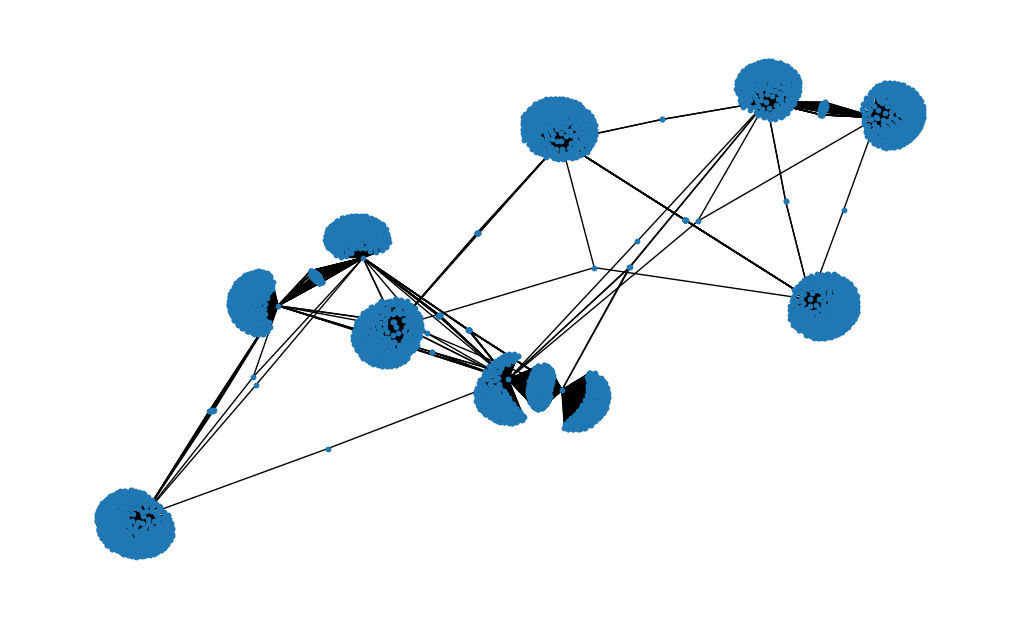

In [88]:
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=False, node_size=10, font_size=8)
plt.show()

In [89]:
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import random

In [ ]:
def compute_transition_matrix(graph):
    """Compute the transition probabilities for a random walk"""
    adjacency = nx.to_numpy_array(graph, dtype=float)  # Convert graph to adjacency matrix
    row_sums = adjacency.sum(axis=1, keepdims=True) # Row sums
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return adjacency / row_sums  # Normalize rows to get transition probabilities

def simulate_random_walk(graph, transition_matrix, steps=100000):
    """Simulate a long random walk to estimate node visit frequencies"""
    nodes = list(graph.nodes)
    node_to_index = {node: idx for idx, node in enumerate(nodes)}  # Map nodes to their indices
    visit_counts = defaultdict(int) # Define a dictionary to store visit counts
    
    #i have to include the fact that the graph could be disconnected
    # Start at a random node
    for i in range(100):
        current_node = np.random.choice(nodes)    
        for _ in range(steps):
            visit_counts[current_node] += 1
            neighbors = list(graph.neighbors(current_node)) # Get neighbors of current node
            if neighbors:
                current_index = node_to_index[current_node]  # Find index of current node
                neighbor_indices = [node_to_index[n] for n in neighbors]  # Find indices of neighbors
                probabilities = np.array([transition_matrix[current_index, idx] for idx in neighbor_indices]) # Get transition probabilities
                probabilities /= probabilities.sum()  # Normalize probabilities
                current_node = np.random.choice(neighbors, p=probabilities) # Move to a neighbor based on probabilities
        
    # Normalize visit counts to get probabilities
    visit_counts = {node: count for node, count in visit_counts.items() if node in graph.nodes}  # Filter out nodes not in graph
    total_visits = sum(visit_counts.values()) # Compute total number of visits for each node
    return {node: visit_counts[node] / total_visits for node in graph.nodes} # Normalize visit counts to get probabilities

def compute_map_equation(graph, transition_matrix, visit_probs, partition):
    """Compute the map equation for the current partitioning"""
    module_probs = defaultdict(float) # Initialize module probabilities
    teleport_term = defaultdict(float) # Initialize teleport probabilities
    non_teleport = defaultdict(float) # Initialize exit probabilities

    tau = 0.01  # Teleport probability
    node_to_index = {node: idx for idx, node in enumerate(graph.nodes)}
    #n = len(set(partition.values()))  # Count the number of unique partitions
    q = defaultdict(float)  # Initialize exit probabilities

    for node, module in partition.items():
        module_probs[module] += visit_probs[node] # Compute module probabilities as sum of visit probabilities 
        #ni = sum(1 for m in graph.nodes if partition[m] == module)  # Count nodes in the partition
        #teleport_term[module] += tau * (n - ni) / (n-1) * visit_probs[node] 
        teleport_term[module] += 0
        for neighbor in graph.neighbors(node): 
            if partition[neighbor] != module: # If neighbor is in a different module
                node_idx = node_to_index[node] # Get index of current node
                neighbor_idx = node_to_index[neighbor]  # Get index of neighbor
                non_teleport[module] +=  (1 - tau) * visit_probs[node] * transition_matrix[node_idx, neighbor_idx]  # Compute exit probabilities

    for module in module_probs.keys():
        q[module] = teleport_term[module] + non_teleport[module]  # Compute exit probabilities

    
    def safe_log2(x):
        return np.log2(x) if x > 0 else 0

    '''
    first_term = sum(q[module] for module in module_probs.keys()) * np.log2(sum(q[module] for module in module_probs.keys()))
    second_term = - 2 * sum(q[module]*np.log2(q[module]) for module in module_probs.keys())
    third_term = - sum(visit_probs[node] * np.log2(visit_probs[node]) for node in graph.nodes)
    fourth_term = sum(q[module] *  sum(visit_probs[node] for node in graph.nodes if partition[node] == module) * np.log2(q[module] * sum(visit_probs[node] for node in graph.nodes if partition[node] == module)) for module in module_probs.keys())
    '''
    first_term = sum(q[module] for module in module_probs.keys()) * safe_log2(sum(q[module] for module in module_probs.keys()))
    second_term = - 2 * sum(q[module] * safe_log2(q[module]) for module in module_probs.keys())
    third_term = - sum(visit_probs[node] * safe_log2(visit_probs[node]) for node in graph.nodes)
    fourth_term = sum((q[module] + module_probs[module]) * (safe_log2(q[module] + module_probs[module])) for module in module_probs.keys())

    description_length = first_term + second_term + third_term + fourth_term

    return description_length # Return the map equation

def optimize_partition(graph, transition_matrix, iterations):
    """Optimize the partitioning to minimize the map equation"""
    visit_probs = simulate_random_walk(graph, transition_matrix)

    partition = {node: node for node in graph.nodes}  # Start with each node as its own module
    for _ in range(iterations):
        for node in graph.nodes:
            best_module = partition[node] # Initialize best module as current module
            best_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) 

            for neighbor in graph.neighbors(node): # Try moving node to each neighbor's module
                partition[node] = partition[neighbor] # Move node to neighbor's module
                new_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) # Compute new map equation score
                if new_score <= best_score: # If new score is better, update best module and score
                    best_module = partition[node]
                    best_score = new_score

            partition[node] = best_module  # Keep the best move
    return partition

def greedy_optimize_partition(graph, transition_matrix, visit_probs, iterations):
    """Greedy search to minimize the map equation by merging best modules."""

    # Start with each node as its own module
    partition = {node: node for node in graph.nodes}
    
    for _ in range(iterations):
        improved = False
        module_list = list(set(partition.values()))  # Get unique communities
        
        for i in range(len(module_list)):  # Merging each pair of communities and see if it improves the map equation
            for j in range(len(module_list)):  # Compare each pair
                if i != j:  # Skip if same community
                    temp_partition = partition.copy() # Temporary partition where we merge module j into module i
                    for node in graph.nodes:
                        if partition[node] == module_list[j]:  
                            temp_partition[node] = module_list[i] # Merge module j into module i
                    
                    old_score = compute_map_equation(graph, transition_matrix, visit_probs, partition) # Compute old map equation
                    new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition) # Compute new map equation
                    
                    if new_score < old_score:  # If merging improves score
                        partition = temp_partition  # Apply the merge
                        improved = True
        
        if not improved:  # Stop if no improvement
            break
    return partition


def simulated_annealing_infomap(graph, transition_matrix, visit_probs, partition, num_iterations):
    """Refine Infomap partition using simulated annealing with heat-bath algorithm."""

    T_start = 5.0    
    T_end = 0.001    
    cooling_rate = 0.99  

    best_partition = partition.copy()
    current_partition = partition.copy()
    best_score = compute_map_equation(graph, transition_matrix, visit_probs, best_partition)
    current_score = best_score

    T = T_start  

    while T > T_end:
        for _ in range(num_iterations):
            node = random.choice(list(graph.nodes))
            current_community = current_partition[node]
            possible_communities = list(set(current_partition.values()) - {current_community})

            if not possible_communities:
                continue  
            
            new_community = random.choice(possible_communities)

            temp_partition = current_partition.copy()
            temp_partition[node] = new_community
            
            new_score = compute_map_equation(graph, transition_matrix, visit_probs, temp_partition)
            delta_L = new_score - current_score  
            
            if delta_L < 0 or np.exp(-delta_L / T) > random.random():
                current_partition = temp_partition.copy()
                current_score = new_score
                
                if new_score < best_score:
                    best_partition = current_partition.copy()
                    best_score = new_score
        
        T *= cooling_rate

    return best_partition

def plot_communities(graph, partition):
    """Plot the network with different colors for different communities"""
    plt.figure(figsize=(10, 7))
    
    # Create a color map for each community
    unique_communities = list(set(partition.values()))
    colors = ["red", "blue", "green", "purple", "orange", "yellow", "black", "gray", "pink", "brown"]
    community_colors = {community: colors[i] for i, community in enumerate(unique_communities)}

    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Draw the graph
    pos = nx.spring_layout(graph, seed=42)  # Layout for visualization
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    
    plt.title("Detected Communities in the Network")
    plt.show()

def plot_communities_sbm(graph, partition):
    """Plot SBM network with different colors for different communities"""
    plt.figure(figsize=(10, 7))
    
    # Identify unique communities and assign colors using the 'turbo' colormap
    unique_communities = list(set(partition.values()))
    #colors = plt.cm.turbo(np.linspace(0, 1, len(unique_communities)))
    colors = ["red", "blue", "green", "purple", "orange", "yellow", "black", "gray", "pink", "brown", "cyan", "magenta", "lime", "navy", "teal", "coral"]
    community_colors = {community: colors[i] for i, community in enumerate(unique_communities)}
    
    # Assign colors to nodes based on their community
    node_colors = [community_colors[partition[node]] for node in graph.nodes]

    # Use the multipartite layout for SBM
    pos = nx.multipartite_layout(graph, subset_key="block")

    # Draw the graph
    nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.5)
    
    plt.title("Detected Communities in SBM")
    plt.show()

In [91]:
transition_matrix = compute_transition_matrix(G)
visit_probs = simulate_random_walk(G, transition_matrix)

In [93]:
greedy_partition = greedy_optimize_partition(G, transition_matrix, visit_probs, iterations=50)

KeyboardInterrupt: 